# DocMatchNet-JEPA Training
=========================
Two-stage training: Alignment Pretraining + Gated SFT

GPU Required: T4 or P100  
Runtime: ~2-3 hours total

In [1]:
# ============================================================
# CELL 1: Setup
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np
from tqdm import tqdm
import json
import os

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set seeds
SEED = 123  # use 42, 123, 456 for multi-seed runs
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Create output directory
os.makedirs('/kaggle/working/results', exist_ok=True)

Using device: cuda
GPU: Tesla T4
Memory: 15.6 GB


In [2]:
# ============================================================
# CELL 2: Load Data
# ============================================================
DATA_DIR = '/kaggle/input/docmatchnet-jepa-data/data'  # Your saved dataset

# Load all tensors
doctor_embeddings = torch.load(f'{DATA_DIR}/doctor_embeddings.pt', weights_only=False)
case_embeddings = torch.load(f'{DATA_DIR}/case_embeddings.pt', weights_only=False)
clinical_features = torch.load(f'{DATA_DIR}/clinical_features.pt', weights_only=False)
pastwork_features = torch.load(f'{DATA_DIR}/pastwork_features.pt', weights_only=False)
logistics_features = torch.load(f'{DATA_DIR}/logistics_features.pt', weights_only=False)
trust_features = torch.load(f'{DATA_DIR}/trust_features.pt', weights_only=False)
context_features = torch.load(f'{DATA_DIR}/context_features.pt', weights_only=False)
relevance_labels = torch.load(f'{DATA_DIR}/relevance_labels.pt', weights_only=False)
doctor_indices = torch.load(f'{DATA_DIR}/doctor_indices.pt', weights_only=False)
mcda_scores = torch.load(f'{DATA_DIR}/mcda_scores.pt', weights_only=False)
case_metadata = torch.load(f'{DATA_DIR}/case_metadata.pt', weights_only=False)
splits = torch.load(f'{DATA_DIR}/splits.pt', weights_only=False)


print(f"Loaded data:")
print(f"  Doctor embeddings: {doctor_embeddings.shape}")
print(f"  Case embeddings: {case_embeddings.shape}")
print(f"  Clinical features: {clinical_features.shape}")
print(f"  Train/Val/Test: {len(splits['train'])}/{len(splits['val'])}/{len(splits['test'])}")

Loaded data:
  Doctor embeddings: torch.Size([500, 384])
  Case embeddings: torch.Size([15000, 384])
  Clinical features: torch.Size([15000, 100, 4])
  Train/Val/Test: 10500/2250/2250


In [3]:
# ============================================================
# CELL 3: Dataset Class
# ============================================================
class DocMatchDatasetJEPA(Dataset):
    """Dataset for JEPA training with InfoNCE loss."""
    
    def __init__(self, indices, case_emb, doc_emb, doc_indices,
                 clinical, pastwork, logistics, trust, context,
                 relevance, metadata):
        self.indices = indices
        self.case_emb = case_emb
        self.doc_emb = doc_emb
        self.doc_indices = doc_indices
        self.clinical = clinical
        self.pastwork = pastwork
        self.logistics = logistics
        self.trust = trust
        self.context = context
        self.relevance = relevance
        self.metadata = metadata
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        case_idx = self.indices[idx]
        rel = self.relevance[case_idx]
        
        # Get positive doctor (relevance >= 3)
        pos_mask = rel >= 3
        if pos_mask.sum() == 0:
            pos_mask = rel >= 2
        if pos_mask.sum() == 0:
            pos_mask = rel == rel.max()
        
        pos_local_idx = torch.where(pos_mask)[0]
        pos_idx = pos_local_idx[torch.randint(len(pos_local_idx), (1,))].item()
        
        # Get negative doctor (relevance <= 1)
        neg_mask = rel <= 1
        if neg_mask.sum() == 0:
            neg_mask = rel < rel.max()
        
        neg_local_idx = torch.where(neg_mask)[0]
        neg_idx = neg_local_idx[torch.randint(len(neg_local_idx), (1,))].item()
        
        # Get global doctor indices
        pos_doc_global = self.doc_indices[case_idx, pos_idx]
        neg_doc_global = self.doc_indices[case_idx, neg_idx]
        
        return {
            'case_embedding': self.case_emb[case_idx],
            'pos_doctor_embedding': self.doc_emb[pos_doc_global],
            'neg_doctor_embedding': self.doc_emb[neg_doc_global],
            'pos_clinical': self.clinical[case_idx, pos_idx],
            'neg_clinical': self.clinical[case_idx, neg_idx],
            'pos_pastwork': self.pastwork[case_idx, pos_idx],
            'neg_pastwork': self.pastwork[case_idx, neg_idx],
            'pos_logistics': self.logistics[case_idx, pos_idx],
            'neg_logistics': self.logistics[case_idx, neg_idx],
            'pos_trust': self.trust[case_idx, pos_idx],
            'neg_trust': self.trust[case_idx, neg_idx],
            'context': self.context[case_idx],
            'pos_relevance': rel[pos_idx],
            'neg_relevance': rel[neg_idx],
            'context_category': self.metadata['context_category'][case_idx]
        }


class DocMatchDatasetEval(Dataset):
    """Dataset for evaluation (listwise)."""
    
    def __init__(self, indices, case_emb, doc_emb, doc_indices,
                 clinical, pastwork, logistics, trust, context,
                 relevance, metadata):
        self.indices = indices
        self.case_emb = case_emb
        self.doc_emb = doc_emb
        self.doc_indices = doc_indices
        self.clinical = clinical
        self.pastwork = pastwork
        self.logistics = logistics
        self.trust = trust
        self.context = context
        self.relevance = relevance
        self.metadata = metadata
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        case_idx = self.indices[idx]
        doc_global_indices = self.doc_indices[case_idx]
        
        return {
            'case_embedding': self.case_emb[case_idx],
            'doctor_embeddings': self.doc_emb[doc_global_indices],
            'clinical': self.clinical[case_idx],
            'pastwork': self.pastwork[case_idx],
            'logistics': self.logistics[case_idx],
            'trust': self.trust[case_idx],
            'context': self.context[case_idx],
            'relevance': self.relevance[case_idx],
            'context_category': self.metadata['context_category'][case_idx]
        }

# Create datasets
train_ds = DocMatchDatasetJEPA(
    splits['train'], case_embeddings, doctor_embeddings, doctor_indices,
    clinical_features, pastwork_features, logistics_features, trust_features,
    context_features, relevance_labels, case_metadata
)

val_ds = DocMatchDatasetEval(
    splits['val'], case_embeddings, doctor_embeddings, doctor_indices,
    clinical_features, pastwork_features, logistics_features, trust_features,
    context_features, relevance_labels, case_metadata
)

test_ds = DocMatchDatasetEval(
    splits['test'], case_embeddings, doctor_embeddings, doctor_indices,
    clinical_features, pastwork_features, logistics_features, trust_features,
    context_features, relevance_labels, case_metadata
)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

Train batches: 83
Val samples: 2250
Test samples: 2250


In [4]:
# ============================================================
# CELL 4: DocMatchNet-JEPA Model
# ============================================================
class DocMatchNetJEPA(nn.Module):
    """DocMatchNet with JEPA-style embedding prediction."""
    
    def __init__(self, embed_dim=384, latent_dim=256, gate_dim=32,
                 context_dim=8, dropout=0.1):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.gate_dim = gate_dim
        
        # Patient Encoder (X-Encoder)
        self.patient_encoder = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(512, latent_dim),
            nn.LayerNorm(latent_dim)
        )
        
        # Doctor Encoder (Y-Encoder) - learns slower
        self.doctor_encoder = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(512, latent_dim),
            nn.LayerNorm(latent_dim)
        )
        
        # Dimension Encoders
        self.clinical_encoder = self._make_encoder(4, gate_dim)
        self.pastwork_encoder = self._make_encoder(5, gate_dim)
        self.logistics_encoder = self._make_encoder(5, gate_dim)
        self.trust_encoder = self._make_encoder(3, gate_dim)
        
        # Context-Aware Gates
        gate_input_dim = latent_dim + context_dim
        self.clinical_gate = self._make_gate(gate_input_dim, gate_dim)
        self.pastwork_gate = self._make_gate(gate_input_dim, gate_dim)
        self.logistics_gate = self._make_gate(gate_input_dim, gate_dim)
        self.trust_gate = self._make_gate(gate_input_dim, gate_dim)
        
        # Initialize gate biases
        self._init_gate_biases()
        
        # Predictor
        predictor_input_dim = latent_dim + gate_dim * 4
        self.predictor = nn.Sequential(
            nn.Linear(predictor_input_dim, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, latent_dim)
        )
        
        # Projection heads
        self.predictor_proj = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.GELU(),
            nn.Linear(latent_dim, 128)
        )
        self.doctor_proj = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.GELU(),
            nn.Linear(latent_dim, 128)
        )
        
        # Learnable temperature
        self.log_temperature = nn.Parameter(torch.log(torch.tensor(0.07)))
        
    def _make_encoder(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.GELU(),
            nn.Linear(output_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.GELU()
        )
        
    def _make_gate(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.GELU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )
        
    def _init_gate_biases(self):
        nn.init.constant_(self.clinical_gate[-2].bias, 0.4)
        nn.init.constant_(self.pastwork_gate[-2].bias, 0.0)
        nn.init.constant_(self.logistics_gate[-2].bias, 0.0)
        nn.init.constant_(self.trust_gate[-2].bias, -0.4)
        
    def forward(self, patient_emb, doctor_emb, clinical, pastwork,
                logistics, trust, context):
        # Encode
        patient_latent = self.patient_encoder(patient_emb)
        doctor_latent = self.doctor_encoder(doctor_emb)
        
        # Encode features
        enc_clinical = self.clinical_encoder(clinical)
        enc_pastwork = self.pastwork_encoder(pastwork)
        enc_logistics = self.logistics_encoder(logistics)
        enc_trust = self.trust_encoder(trust)
        
        # Compute gates
        gate_input = torch.cat([patient_latent, context], dim=-1)
        g_clinical = self.clinical_gate(gate_input)
        g_pastwork = self.pastwork_gate(gate_input)
        g_logistics = self.logistics_gate(gate_input)
        g_trust = self.trust_gate(gate_input)
        
        # Gated fusion
        gated_features = torch.cat([
            g_clinical * enc_clinical,
            g_pastwork * enc_pastwork,
            g_logistics * enc_logistics,
            g_trust * enc_trust
        ], dim=-1)
        
        # Predict ideal doctor
        predictor_input = torch.cat([patient_latent, gated_features], dim=-1)
        predicted_ideal = self.predictor(predictor_input)
        
        # Project
        pred_proj = self.predictor_proj(predicted_ideal)
        doc_proj = self.doctor_proj(doctor_latent)
        
        # Score
        pred_norm = F.normalize(pred_proj, dim=-1)
        doc_norm = F.normalize(doc_proj, dim=-1)
        score = (pred_norm * doc_norm).sum(dim=-1, keepdim=True)
        score = (score + 1) / 2
        
        gate_means = {
            'clinical': g_clinical.mean(dim=-1),
            'pastwork': g_pastwork.mean(dim=-1),
            'logistics': g_logistics.mean(dim=-1),
            'trust': g_trust.mean(dim=-1)
        }
        
        gates = {
            'clinical': g_clinical,
            'pastwork': g_pastwork,
            'logistics': g_logistics,
            'trust': g_trust
        }
        
        return {
            'score': score,
            'predicted_ideal': pred_proj,
            'doctor_embedding': doc_proj,
            'gates': gates,
            'gate_means': gate_means,
            'temperature': self.log_temperature.exp()
        }
    
    def get_parameter_groups(self, base_lr, doctor_lr_mult=0.05):
        doctor_params = list(self.doctor_encoder.parameters()) + \
                       list(self.doctor_proj.parameters())
        doctor_param_ids = set(id(p) for p in doctor_params)
        
        other_params = [p for p in self.parameters() 
                       if id(p) not in doctor_param_ids]
        
        return [
            {'params': other_params, 'lr': base_lr},
            {'params': doctor_params, 'lr': base_lr * doctor_lr_mult}
        ]
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Create model
model = DocMatchNetJEPA().to(device)
print(f"Model parameters: {model.count_parameters():,}")

Model parameters: 1,170,081


In [5]:
# ============================================================
# CELL 5: Loss Functions
# ============================================================
class InfoNCELoss(nn.Module):
    """Bi-directional InfoNCE loss."""
    
    def forward(self, pred_emb, target_emb, temperature):
        pred_norm = F.normalize(pred_emb, dim=-1)
        target_norm = F.normalize(target_emb, dim=-1)
        
        logits = pred_norm @ target_norm.T / temperature
        
        batch_size = logits.shape[0]
        labels = torch.arange(batch_size, device=logits.device)
        
        loss_p2t = F.cross_entropy(logits, labels)
        loss_t2p = F.cross_entropy(logits.T, labels)
        loss = (loss_p2t + loss_t2p) / 2
        
        with torch.no_grad():
            acc = ((logits.argmax(1) == labels).float().mean() +
                   (logits.T.argmax(1) == labels).float().mean()) / 2
        
        return loss, acc.item()


class VICRegGateLoss(nn.Module):
    """VICReg-style gate regularization."""
    
    def forward(self, gates_dict):
        total_loss = 0
        
        for gate_vals in gates_dict.values():
            # Variance loss
            var_loss = F.relu(1.0 - gate_vals.var(dim=0)).mean()
            
            # Covariance loss
            if gate_vals.shape[1] > 1:
                centered = gate_vals - gate_vals.mean(dim=0)
                cov = (centered.T @ centered) / (gate_vals.shape[0] - 1)
                off_diag = cov - torch.diag(cov.diag())
                cov_loss = (off_diag ** 2).mean()
            else:
                cov_loss = 0
            
            total_loss += var_loss + 0.1 * cov_loss
        
        return total_loss / len(gates_dict)


infonce_loss = InfoNCELoss()
vicreg_loss = VICRegGateLoss()

In [6]:
# ============================================================
# CELL 6: Evaluation Function
# ============================================================
def ndcg_at_k(scores, labels, k):
    """Compute NDCG@k."""
    ranking = np.argsort(-scores)[:k]
    dcg = sum((2**labels[r] - 1) / np.log2(i + 2) 
              for i, r in enumerate(ranking))
    
    ideal_ranking = np.argsort(-labels)[:k]
    idcg = sum((2**labels[r] - 1) / np.log2(i + 2) 
               for i, r in enumerate(ideal_ranking))
    
    return dcg / idcg if idcg > 0 else 0

def evaluate(model, dataloader, device):
    """Evaluate model on dataloader."""
    model.eval()
    
    all_ndcg5 = []
    all_ndcg10 = []
    all_map = []
    
    context_results = {}
    gate_activations = {g: [] for g in ['clinical', 'pastwork', 'logistics', 'trust']}
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            case_emb = batch['case_embedding'].to(device)
            doc_embs = batch['doctor_embeddings'].squeeze(0).to(device)
            clinical = batch['clinical'].squeeze(0).to(device)
            pastwork = batch['pastwork'].squeeze(0).to(device)
            logistics = batch['logistics'].squeeze(0).to(device)
            trust = batch['trust'].squeeze(0).to(device)
            context = batch['context'].to(device)
            relevance = batch['relevance'].squeeze(0).numpy()
            ctx_cat = batch['context_category'][0]
            
            # Score all doctors
            scores = []
            for i in range(doc_embs.shape[0]):
                output = model(
                    case_emb, doc_embs[i:i+1],
                    clinical[i:i+1], pastwork[i:i+1],
                    logistics[i:i+1], trust[i:i+1],
                    context
                )
                scores.append(output['score'].item())
                
                # Collect gate activations (from first doctor only)
                if i == 0:
                    for g_name, g_val in output['gate_means'].items():
                        gate_activations[g_name].append(g_val.item())
            
            scores = np.array(scores)
            
            # Compute metrics
            ndcg5 = ndcg_at_k(scores, relevance, 5)
            ndcg10 = ndcg_at_k(scores, relevance, 10)
            
            all_ndcg5.append(ndcg5)
            all_ndcg10.append(ndcg10)
            
            # Store by context
            if ctx_cat not in context_results:
                context_results[ctx_cat] = []
            context_results[ctx_cat].append(ndcg5)
    
    results = {
        'ndcg@5': (np.mean(all_ndcg5), np.std(all_ndcg5)),
        'ndcg@10': (np.mean(all_ndcg10), np.std(all_ndcg10))
    }
    
    stratified = {ctx: (np.mean(vals), np.std(vals)) 
                  for ctx, vals in context_results.items()}
    
    gate_stats = {g: np.mean(vals) for g, vals in gate_activations.items()}
    
    return results, stratified, gate_stats

In [7]:
# ============================================================
# CELL 7: Training Loop
# ============================================================
# Hyperparameters
STAGE1_EPOCHS = 20
STAGE2_EPOCHS = 40
STAGE1_LR = 5e-4
STAGE2_LR = 1e-4
LAMBDA_GATE = 0.05
PATIENCE = 10

# Optimizer with differential LR
param_groups = model.get_parameter_groups(STAGE2_LR, doctor_lr_mult=0.05)
optimizer = AdamW(param_groups, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Training history
history = {
    'train_loss': [],
    'infonce_acc': [],
    'val_ndcg5': [],
    'gate_stats': [],
    'temperature': []
}

print("=" * 60)
print("STAGE 1: Alignment Pretraining")
print("=" * 60)

# Stage 1: Freeze gates, focus on InfoNCE
for name, param in model.named_parameters():
    if 'gate' in name:
        param.requires_grad = False

for epoch in range(STAGE1_EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    n_batches = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        # Move to device
        case_emb = batch['case_embedding'].to(device)
        pos_doc = batch['pos_doctor_embedding'].to(device)
        pos_clinical = batch['pos_clinical'].to(device)
        pos_pastwork = batch['pos_pastwork'].to(device)
        pos_logistics = batch['pos_logistics'].to(device)
        pos_trust = batch['pos_trust'].to(device)
        context = batch['context'].to(device)
        
        optimizer.zero_grad()
        
        output = model(case_emb, pos_doc, pos_clinical, pos_pastwork,
                      pos_logistics, pos_trust, context)
        
        # InfoNCE loss only
        loss, acc = infonce_loss(output['predicted_ideal'],
                                output['doctor_embedding'],
                                output['temperature'])
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    avg_acc = epoch_acc / n_batches
    
    history['train_loss'].append(avg_loss)
    history['infonce_acc'].append(avg_acc)
    history['temperature'].append(output['temperature'].item())
    
    if epoch % 5 == 0:
        val_results, _, gate_stats = evaluate(model, val_loader, device)
        history['val_ndcg5'].append(val_results['ndcg@5'][0])
        history['gate_stats'].append(gate_stats)
        print(f"Epoch {epoch}: Loss={avg_loss:.4f}, Acc={avg_acc:.4f}, "
              f"Val NDCG@5={val_results['ndcg@5'][0]:.4f}")
    else:
        print(f"Epoch {epoch}: Loss={avg_loss:.4f}, Acc={avg_acc:.4f}")
    
    scheduler.step()

# Unfreeze gates for Stage 2
for name, param in model.named_parameters():
    param.requires_grad = True

print("\n" + "=" * 60)
print("STAGE 2: Gated Supervised Fine-tuning")
print("=" * 60)

best_ndcg = 0
patience_counter = 0

for epoch in range(STAGE2_EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_gate_loss = 0
    n_batches = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        case_emb = batch['case_embedding'].to(device)
        pos_doc = batch['pos_doctor_embedding'].to(device)
        pos_clinical = batch['pos_clinical'].to(device)
        pos_pastwork = batch['pos_pastwork'].to(device)
        pos_logistics = batch['pos_logistics'].to(device)
        pos_trust = batch['pos_trust'].to(device)
        context = batch['context'].to(device)
        
        optimizer.zero_grad()
        
        output = model(case_emb, pos_doc, pos_clinical, pos_pastwork,
                      pos_logistics, pos_trust, context)
        
        # InfoNCE loss
        info_loss, acc = infonce_loss(output['predicted_ideal'],
                                     output['doctor_embedding'],
                                     output['temperature'])
        
        # Gate regularization
        gate_loss = vicreg_loss(output['gates'])
        
        # Total loss
        loss = info_loss + LAMBDA_GATE * gate_loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_gate_loss += gate_loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    avg_acc = epoch_acc / n_batches
    avg_gate_loss = epoch_gate_loss / n_batches
    
    history['train_loss'].append(avg_loss)
    history['infonce_acc'].append(avg_acc)
    history['temperature'].append(output['temperature'].item())
    
    # Validation
    val_results, stratified, gate_stats = evaluate(model, val_loader, device)
    val_ndcg = val_results['ndcg@5'][0]
    history['val_ndcg5'].append(val_ndcg)
    history['gate_stats'].append(gate_stats)
    
    print(f"Epoch {epoch}: Loss={avg_loss:.4f}, Acc={avg_acc:.4f}, "
          f"Gate={avg_gate_loss:.4f}, Val NDCG@5={val_ndcg:.4f}")
    
    # Early stopping
    if val_ndcg > best_ndcg:
        best_ndcg = val_ndcg
        patience_counter = 0
        torch.save(model.state_dict(), '/kaggle/working/results/best_jepa_model.pt')
        print(f"  → New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break
    
    scheduler.step()

STAGE 1: Alignment Pretraining


Evaluating: 100%|██████████| 2250/2250 [07:48<00:00,  4.81it/s]


Epoch 0: Loss=4.7760, Acc=0.0199, Val NDCG@5=0.5189


Epoch 1: Loss=4.5175, Acc=0.0330


Epoch 2: Loss=4.2428, Acc=0.0609


Epoch 3: Loss=4.0131, Acc=0.0823


Epoch 4: Loss=3.8625, Acc=0.1032


Evaluating: 100%|██████████| 2250/2250 [07:47<00:00,  4.82it/s]


Epoch 5: Loss=3.6998, Acc=0.1319, Val NDCG@5=0.5483


Epoch 6: Loss=3.5853, Acc=0.1406


Epoch 7: Loss=3.5212, Acc=0.1533


Epoch 8: Loss=3.4586, Acc=0.1691


Epoch 9: Loss=3.4224, Acc=0.1693


Evaluating: 100%|██████████| 2250/2250 [07:47<00:00,  4.81it/s]


Epoch 10: Loss=3.3675, Acc=0.1821, Val NDCG@5=0.5623


Epoch 11: Loss=3.1603, Acc=0.2211


Epoch 12: Loss=2.9472, Acc=0.2624


Epoch 13: Loss=2.7009, Acc=0.3100


Epoch 14: Loss=2.4798, Acc=0.3567


Evaluating: 100%|██████████| 2250/2250 [07:46<00:00,  4.82it/s]


Epoch 15: Loss=2.3097, Acc=0.3957, Val NDCG@5=0.5537


Epoch 16: Loss=2.1496, Acc=0.4314


Epoch 17: Loss=1.9825, Acc=0.4712


Epoch 18: Loss=1.8238, Acc=0.5082


Epoch 19: Loss=1.7409, Acc=0.5270

STAGE 2: Gated Supervised Fine-tuning


Evaluating: 100%|██████████| 2250/2250 [07:46<00:00,  4.82it/s]


Epoch 0: Loss=1.6558, Acc=0.5614, Gate=0.9999, Val NDCG@5=0.5400
  → New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:48<00:00,  4.80it/s]


Epoch 1: Loss=1.5680, Acc=0.5905, Gate=0.9999, Val NDCG@5=0.5547
  → New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:46<00:00,  4.82it/s]


Epoch 2: Loss=1.4985, Acc=0.5996, Gate=0.9999, Val NDCG@5=0.5468


Evaluating: 100%|██████████| 2250/2250 [07:54<00:00,  4.74it/s]


Epoch 3: Loss=1.4438, Acc=0.6156, Gate=0.9999, Val NDCG@5=0.5548
  → New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:49<00:00,  4.79it/s]


Epoch 4: Loss=1.3892, Acc=0.6230, Gate=0.9999, Val NDCG@5=0.5577
  → New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:46<00:00,  4.82it/s]


Epoch 5: Loss=1.3364, Acc=0.6359, Gate=0.9999, Val NDCG@5=0.5446


Evaluating: 100%|██████████| 2250/2250 [07:49<00:00,  4.79it/s]


Epoch 6: Loss=1.3259, Acc=0.6423, Gate=0.9999, Val NDCG@5=0.5478


Evaluating: 100%|██████████| 2250/2250 [07:46<00:00,  4.83it/s]


Epoch 7: Loss=1.3015, Acc=0.6476, Gate=0.9999, Val NDCG@5=0.5653
  → New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:47<00:00,  4.81it/s]


Epoch 8: Loss=1.2973, Acc=0.6510, Gate=0.9999, Val NDCG@5=0.5389


Evaluating: 100%|██████████| 2250/2250 [07:47<00:00,  4.81it/s]


Epoch 9: Loss=1.3073, Acc=0.6462, Gate=0.9999, Val NDCG@5=0.5551


Evaluating: 100%|██████████| 2250/2250 [07:45<00:00,  4.83it/s]


Epoch 10: Loss=1.2751, Acc=0.6533, Gate=0.9999, Val NDCG@5=0.5473


Evaluating: 100%|██████████| 2250/2250 [07:51<00:00,  4.77it/s]


Epoch 11: Loss=1.1560, Acc=0.6819, Gate=0.9999, Val NDCG@5=0.5451


Evaluating: 100%|██████████| 2250/2250 [07:50<00:00,  4.79it/s]


Epoch 12: Loss=1.0686, Acc=0.6994, Gate=1.0000, Val NDCG@5=0.5317


Evaluating: 100%|██████████| 2250/2250 [07:45<00:00,  4.83it/s]


Epoch 13: Loss=0.9728, Acc=0.7280, Gate=1.0000, Val NDCG@5=0.5593


Evaluating: 100%|██████████| 2250/2250 [07:44<00:00,  4.84it/s]


Epoch 14: Loss=0.8795, Acc=0.7431, Gate=1.0000, Val NDCG@5=0.5307


Evaluating: 100%|██████████| 2250/2250 [07:43<00:00,  4.86it/s]


Epoch 15: Loss=0.8239, Acc=0.7607, Gate=1.0000, Val NDCG@5=0.5341


Evaluating: 100%|██████████| 2250/2250 [07:45<00:00,  4.83it/s]


Epoch 16: Loss=0.7367, Acc=0.7810, Gate=1.0000, Val NDCG@5=0.5539


Evaluating: 100%|██████████| 2250/2250 [07:47<00:00,  4.81it/s]


Epoch 17: Loss=0.6896, Acc=0.7821, Gate=1.0000, Val NDCG@5=0.5679
  → New best model saved!


Evaluating: 100%|██████████| 2250/2250 [07:45<00:00,  4.84it/s]


Epoch 18: Loss=0.6418, Acc=0.7985, Gate=1.0000, Val NDCG@5=0.5311


Evaluating: 100%|██████████| 2250/2250 [07:46<00:00,  4.82it/s]


Epoch 19: Loss=0.6105, Acc=0.8047, Gate=1.0000, Val NDCG@5=0.5349


Evaluating: 100%|██████████| 2250/2250 [07:48<00:00,  4.80it/s]


Epoch 20: Loss=0.5713, Acc=0.8119, Gate=1.0000, Val NDCG@5=0.5345


Evaluating: 100%|██████████| 2250/2250 [07:48<00:00,  4.81it/s]


Epoch 21: Loss=0.5473, Acc=0.8149, Gate=1.0000, Val NDCG@5=0.5667


Evaluating: 100%|██████████| 2250/2250 [07:48<00:00,  4.80it/s]


Epoch 22: Loss=0.5223, Acc=0.8218, Gate=1.0000, Val NDCG@5=0.5563


Evaluating: 100%|██████████| 2250/2250 [07:45<00:00,  4.83it/s]


Epoch 23: Loss=0.4959, Acc=0.8231, Gate=1.0000, Val NDCG@5=0.5415


Evaluating: 100%|██████████| 2250/2250 [07:48<00:00,  4.80it/s]


Epoch 24: Loss=0.4998, Acc=0.8170, Gate=1.0000, Val NDCG@5=0.5568


Evaluating: 100%|██████████| 2250/2250 [07:45<00:00,  4.83it/s]


Epoch 25: Loss=0.4722, Acc=0.8235, Gate=1.0000, Val NDCG@5=0.5156


Evaluating: 100%|██████████| 2250/2250 [07:46<00:00,  4.82it/s]


Epoch 26: Loss=0.4582, Acc=0.8314, Gate=1.0000, Val NDCG@5=0.5666


Evaluating: 100%|██████████| 2250/2250 [07:44<00:00,  4.85it/s]

Epoch 27: Loss=0.4463, Acc=0.8312, Gate=1.0000, Val NDCG@5=0.5274
Early stopping at epoch 27


In [8]:
# ============================================================
# CELL 8: Final Evaluation
# ============================================================
print("\n" + "=" * 60)
print("FINAL EVALUATION ON TEST SET")
print("=" * 60)

# Load best model
model.load_state_dict(torch.load('/kaggle/working/results/best_jepa_model.pt'))

test_results, test_stratified, test_gates = evaluate(model, test_loader, device)

print("\nOverall Results:")
for metric, (mean, std) in test_results.items():
    print(f"  {metric}: {mean:.4f} ± {std:.4f}")

print("\nStratified Results (NDCG@5):")
for ctx, (mean, std) in test_stratified.items():
    print(f"  {ctx}: {mean:.4f} ± {std:.4f}")

print("\nGate Activations:")
for gate, val in test_gates.items():
    print(f"  {gate}: {val:.4f}")

# Save results
results = {
    'overall': {k: {'mean': v[0], 'std': v[1]} 
                for k, v in test_results.items()},
    'stratified': {k: {'mean': v[0], 'std': v[1]} 
                   for k, v in test_stratified.items()},
    'gate_stats': test_gates,
    'history': history
}

with open('/kaggle/working/results/jepa_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✅ Results saved to /kaggle/working/results/jepa_results.json")


FINAL EVALUATION ON TEST SET


Evaluating: 100%|██████████| 2250/2250 [07:47<00:00,  4.81it/s]


Overall Results:
  ndcg@5: 0.5676 ± 0.2053
  ndcg@10: 0.5778 ± 0.1676

Stratified Results (NDCG@5):
  rare_disease: 0.5698 ± 0.1588
  complex: 0.6122 ± 0.1837
  routine: 0.5308 ± 0.1938
  emergency: 0.5355 ± 0.1965
  pediatric: 0.9348 ± 0.0720

Gate Activations:
  clinical: 0.5000
  pastwork: 0.8810
  logistics: 0.5351
  trust: 0.7173

✅ Results saved to /kaggle/working/results/jepa_results.json


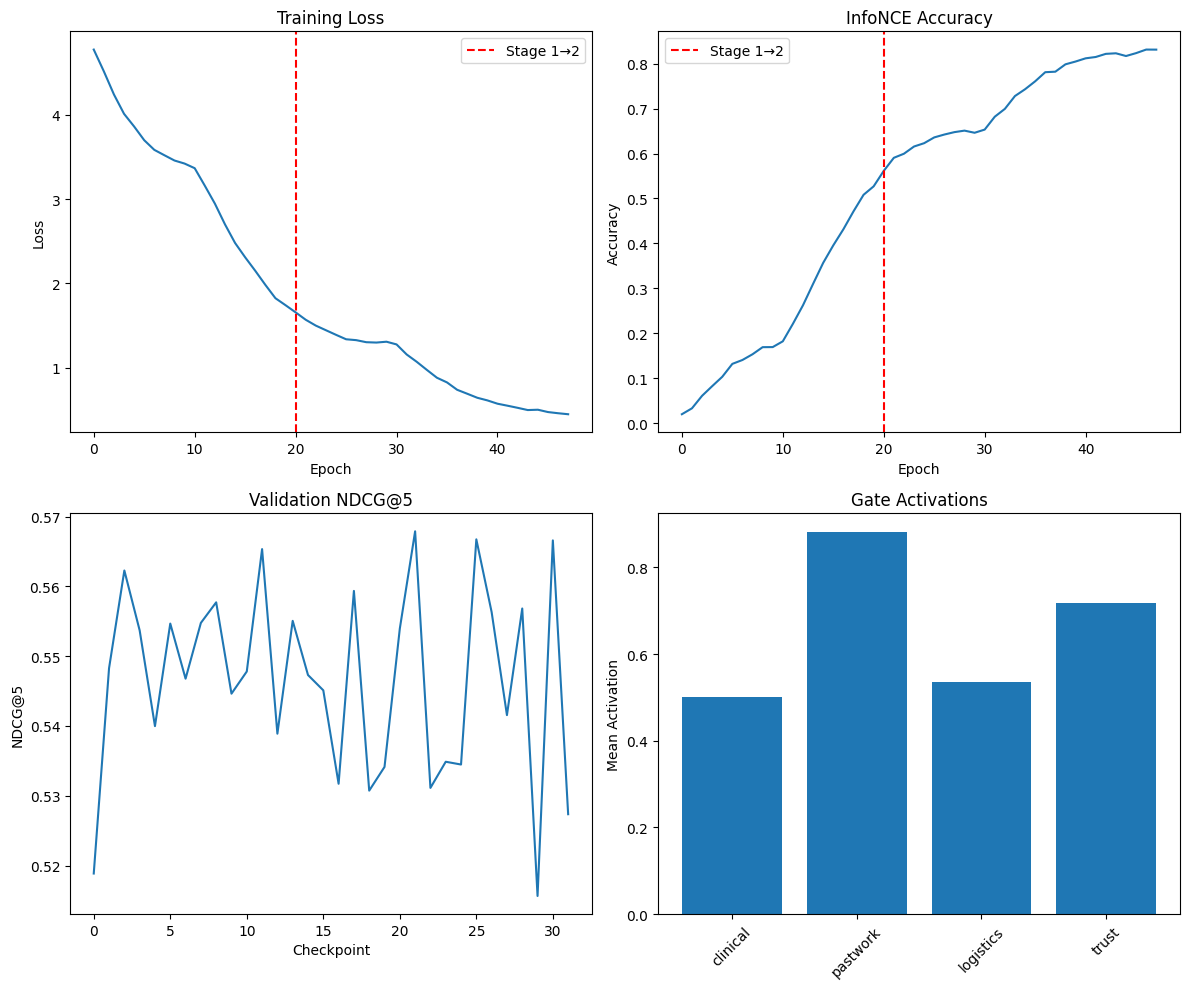


✅ Training complete!


In [9]:
# ============================================================
# CELL 9: Visualizations
# ============================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Training loss
ax = axes[0, 0]
ax.plot(history['train_loss'])
ax.axvline(STAGE1_EPOCHS, color='r', linestyle='--', label='Stage 1→2')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()

# InfoNCE accuracy
ax = axes[0, 1]
ax.plot(history['infonce_acc'])
ax.axvline(STAGE1_EPOCHS, color='r', linestyle='--', label='Stage 1→2')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('InfoNCE Accuracy')
ax.legend()

# Validation NDCG@5
ax = axes[1, 0]
val_epochs = list(range(0, STAGE1_EPOCHS, 5)) + list(range(STAGE1_EPOCHS, len(history['val_ndcg5'])))
ax.plot(history['val_ndcg5'])
ax.set_xlabel('Checkpoint')
ax.set_ylabel('NDCG@5')
ax.set_title('Validation NDCG@5')

# Gate activations
ax = axes[1, 1]
contexts = list(test_stratified.keys())
gates = ['clinical', 'pastwork', 'logistics', 'trust']
x = np.arange(len(gates))
ax.bar(x, [test_gates[g] for g in gates])
ax.set_xticks(x)
ax.set_xticklabels(gates, rotation=45)
ax.set_ylabel('Mean Activation')
ax.set_title('Gate Activations')

plt.tight_layout()
plt.savefig('/kaggle/working/results/jepa_training_curves.png', dpi=150)
plt.show()

print("\n✅ Training complete!")

In [10]:
# ============================================================
# CELL 10: Save Embeddings for t-SNE Visualization
# ============================================================

def save_embeddings_for_visualization(model, test_ds, device,
                                       save_path, n_samples=1000):
    """
    Extract and save embeddings from the trained model
    for t-SNE visualization in Figure 4.
    """
    model.eval()

    patient_latents = []
    predicted_ideals = []
    doctor_latents = []
    specialties = []
    contexts = []

    n_samples = min(n_samples, len(test_ds))
    indices = np.random.choice(len(test_ds), n_samples, replace=False)

    with torch.no_grad():
        for idx in tqdm(indices, desc="Extracting embeddings"):
            sample = test_ds[idx]
            case_emb = sample['case_embedding'].unsqueeze(0).to(device)
            context = sample['context'].unsqueeze(0).to(device)

            # Best matching doctor (highest relevance)
            rel = sample['relevance']
            best_doc_idx = rel.argmax().item()

            doc_emb = sample['doctor_embeddings'][best_doc_idx:best_doc_idx+1].to(device)
            clinical = sample['clinical'][best_doc_idx:best_doc_idx+1].to(device)
            pastwork = sample['pastwork'][best_doc_idx:best_doc_idx+1].to(device)
            logistics = sample['logistics'][best_doc_idx:best_doc_idx+1].to(device)
            trust = sample['trust'][best_doc_idx:best_doc_idx+1].to(device)

            output = model(case_emb, doc_emb, clinical, pastwork,
                           logistics, trust, context)

            # Robust extraction: use model outputs when available, otherwise derive from encoders
            patient_latent = output.get('patient_latent', model.patient_encoder(case_emb))
            doctor_latent = output.get('doctor_latent', model.doctor_encoder(doc_emb))
            predicted_ideal = output['predicted_ideal']

            patient_latents.append(patient_latent.cpu().numpy())
            predicted_ideals.append(predicted_ideal.cpu().numpy())
            doctor_latents.append(doctor_latent.cpu().numpy())

            case_global_idx = splits['test'][idx]
            specialties.append(case_metadata['target_specialty'][case_global_idx])
            contexts.append(sample['context_category'])

    embeddings_data = {
        'patient_latents': np.concatenate(patient_latents, axis=0),
        'predicted_ideals': np.concatenate(predicted_ideals, axis=0),
        'doctor_latents': np.concatenate(doctor_latents, axis=0),
        'specialties': specialties,
        'contexts': contexts
    }

    torch.save(embeddings_data, save_path)
    print(f"Saved {n_samples} embedding samples to {save_path}")

    return embeddings_data


# Run after training is complete
embedding_data = save_embeddings_for_visualization(
    model, test_ds, device,
    f'/kaggle/working/results/jepa_seed{SEED}_embeddings.pt',
    n_samples=1000
)



Extracting embeddings: 100%|██████████| 1000/1000 [00:02<00:00, 363.35it/s]

Saved 1000 embedding samples to /kaggle/working/results/jepa_seed123_embeddings.pt


In [11]:
import os, shutil

src_dir = "/kaggle/working/results"
dst_dir = f"/kaggle/working/results/seed_{SEED}"
os.makedirs(dst_dir, exist_ok=True)

files = [
    "best_jepa_model.pt",
    f"jepa_seed{SEED}_embeddings.pt",   # already seed-named
    "jepa_results.json",
    "jepa_training_curves.png",
]

for f in files:
    src = os.path.join(src_dir, f)
    if os.path.exists(src):
        if f.startswith("jepa_seed"):  # already correct name
            out_name = f
        else:
            out_name = f.replace("jepa", f"jepa_seed{SEED}")
        shutil.copy2(src, os.path.join(dst_dir, out_name))
        print("copied:", f, "->", out_name)
    else:
        print("missing:", f)


copied: best_jepa_model.pt -> best_jepa_seed123_model.pt
copied: jepa_seed123_embeddings.pt -> jepa_seed123_embeddings.pt
copied: jepa_results.json -> jepa_seed123_results.json
copied: jepa_training_curves.png -> jepa_seed123_training_curves.png
